# Ejercicio Nº 2

En el siguiente problema, se presenta un conjunto de datos sobre diferentes variedades de frijoles secos. El objetivo es desarrollar un modelo de clasificación que pueda distinguir entre siete variedades registradas de frijoles secos, utilizando características como forma, tamaño, tipo y estructura. Se utilizó un sistema de visión por computadora para obtener imágenes de los granos de frijol y luego se llevó a cabo la segmentación y extracción de características para obtener un total de 16 atributos, incluidas 12 dimensiones y 4 formas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math
import os
import seaborn as sns

Cargamos el archivo CSV

In [2]:
path = 'TP1-2/dataset/Dry-Bean-Dataset.csv'
if os.path.exists(path):
    df = pd.read_csv(path)


### Análisis exploratorio del Dataset

In [3]:
def info(df):
    """
    Describe el DataFrame y muestra información sobre los datos faltantes.
    """
    print(df.head())
    print(df.describe())
    print(df.info())
    print(f'Shape: {df.shape}')

    vacios_original=df.isna().sum()
    print(f"Datos vacíos:\n{vacios_original}")

In [4]:
def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(2 * num_rows, 5 * num_cols))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=10)
        axs[row, col_idx].set_ylabel("Count",fontsize=5)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=5)
        axs[row, col_idx].tick_params(axis='y', labelsize=5)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    
    fig.suptitle(f"Histogramas de variales numéricas", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

In [5]:
def matriz_correlacion(df):
    # Calcula la matriz de correlación
    corr = df.select_dtypes(include=[float, int]).corr()

    # Ajusta el tamaño de la figura
    plt.figure(figsize=(14, 10))

    # Crea el heatmap
    ax = sns.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        annot_kws={'size': 10},  # Ajusta el tamaño de las anotaciones
        fmt=".2f"  # Formato de los valores de anotación
    )

    # Ajusta las etiquetas del eje x
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=10  # Ajusta el tamaño de la fuente de las etiquetas
    )

    # Ajusta las etiquetas del eje y
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=10  # Ajusta el tamaño de la fuente de las etiquetas
    )

    # Añade un título general a la figura
    ax.set_title("Matriz de Correlación", fontsize=15)
    
    # Ajusta el layout para que no se superpongan los elementos
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Muestra la figura
    plt.show()
def global_boxplots(df):
    columnas_numericas = df.select_dtypes(include=['number'])
    
    if columnas_numericas.empty:
        print("No hay columnas numéricas en el DataFrame.")
        return
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title("Boxplots para todas las variables")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()


def scatter_plot(df):
    numeric_cols = df.select_dtypes(include=['number'])
    num_plots = len(numeric_cols.columns)
    
    # Determina el número de filas y columnas para la matriz
    num_rows = (num_plots + 2) // 3  # Redondea hacia arriba
    num_cols = min(num_plots, 3)

    # Aumenta el tamaño de la figura
    figsize = (15, num_rows * 3)  # Aumenta la altura de la figura
    
    # Crea una figura de Matplotlib con subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, col in enumerate(numeric_cols.columns):
        row = i // num_cols
        col_num = i % num_cols  # Cambia el nombre de la variable para evitar la confusión

        # Selecciona el subplot actual
        ax = axes[row, col_num]

        # Crea el gráfico de dispersión en el subplot
        sns.scatterplot(x=col, y='Class', data=df, ax=ax)
        ax.set_title(col)  # Configura el título del subplot

    # Elimina subplots no utilizados
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col_num = i % num_cols
        fig.delaxes(axes[row, col_num])

    plt.tight_layout()
    plt.show()

Analizamos si las clases objetivo estan balancedas

In [6]:
def check_balance(df):
    """
    Calcula el balance de clases para las columnas objetivo en un DataFrame.
    """
    # Graficar el balance de las clases
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Class', order=df['Class'].value_counts().index)
    plt.title('Balance de las clases en todo el conjunto de datos')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.show()

Graficamos

In [7]:
def graficos(df):
    """
    Graficos de variables numéricas y matriz de correlación
    """
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles en el DataFrame: {len(df)}")
    plot_variables(df)
    matriz_correlacion(df)
    global_boxplots(df)
    scatter_plot(df)
    check_balance(df)

    Area  Perimeter  MajorAxisLength  MinorAxisLength  Eccentricity  \
0  28395    610.291       208.178117       173.888747      0.549812   
1  28734    638.018       200.524796       182.734419      0.411785   
2  29380    624.110       212.826130       175.931143      0.562727   
3  30008    645.884       210.557999       182.516516      0.498616   
4  30140    620.134       201.847882       190.279279      0.333680   

   ConvexArea  EquivDiameter    Extent  Solidity  Compactness  ShapeFactor1  \
0       28715     190.141097  0.763923  0.988856     0.913358      0.007332   
1       29172     191.272750  0.783968  0.984986     0.953861      0.006979   
2       29690     193.410904  0.778113  0.989559     0.908774      0.007244   
3       30724     195.467062  0.782681  0.976696     0.928329      0.007017   
4       30417     195.896503  0.773098  0.990893     0.970516      0.006697   

   ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0      0.003147      0.834222      0.998724  

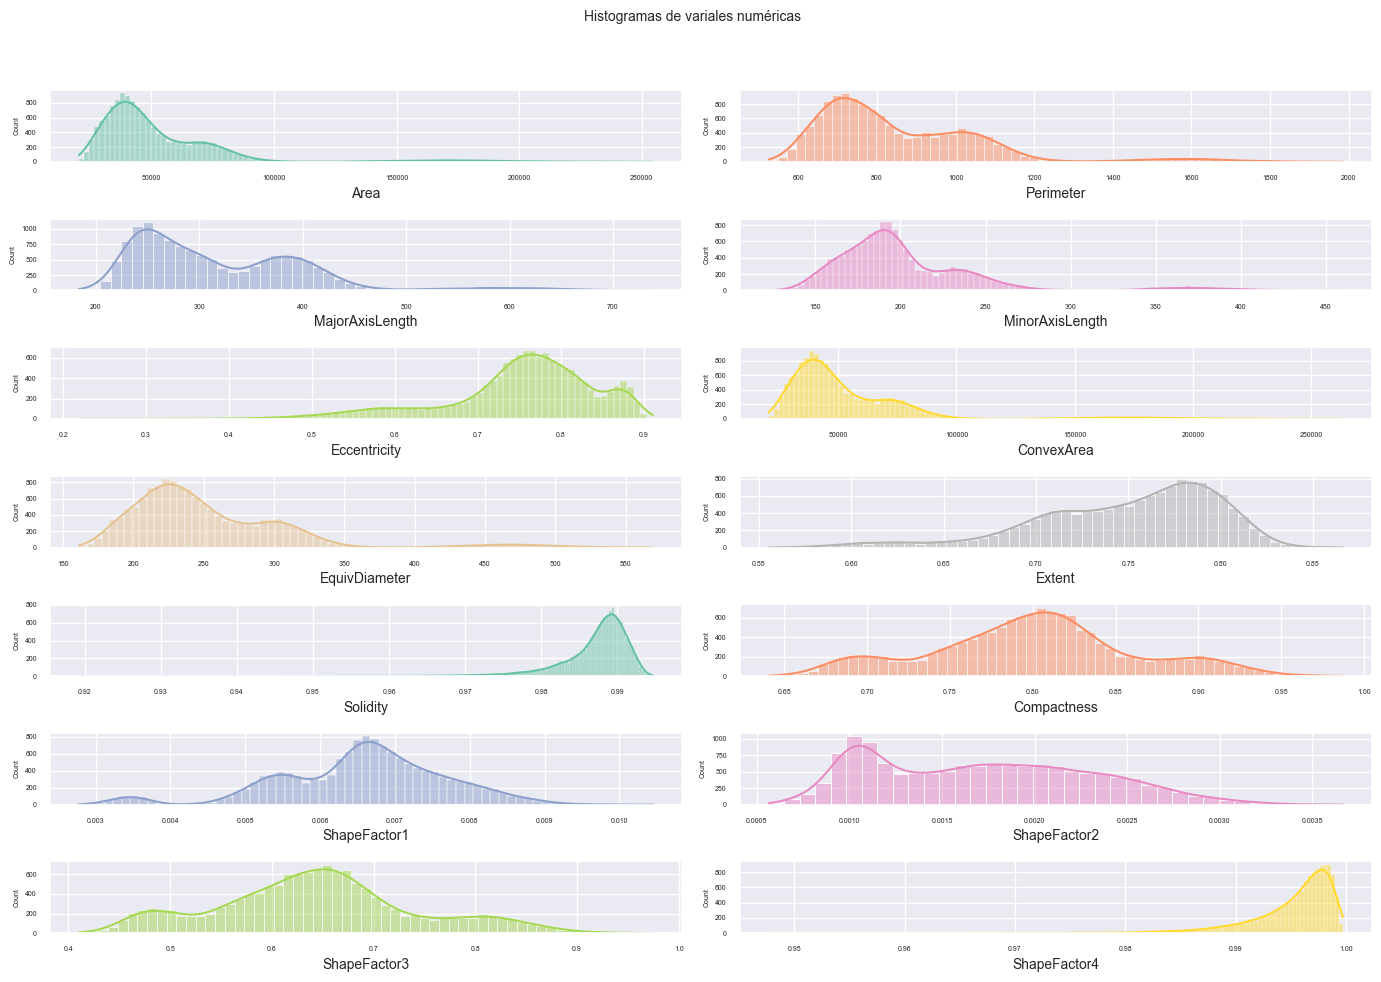

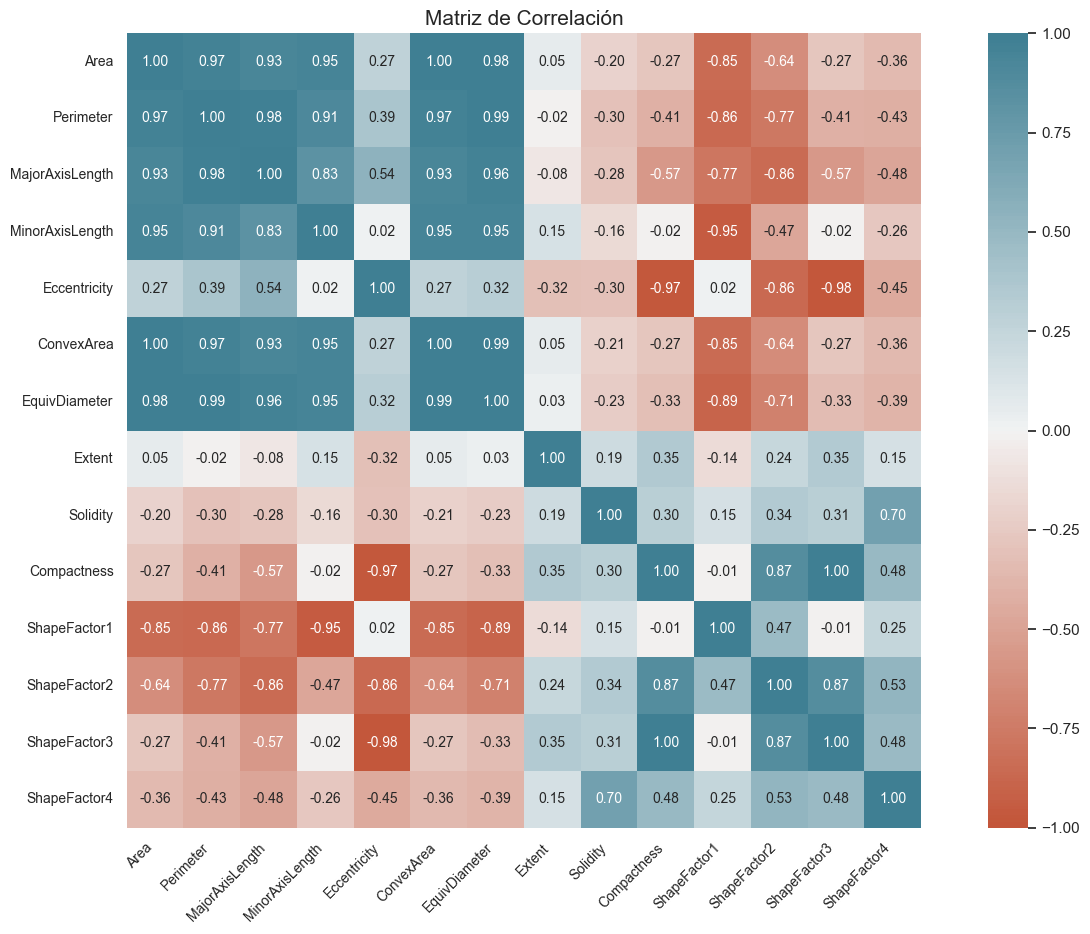

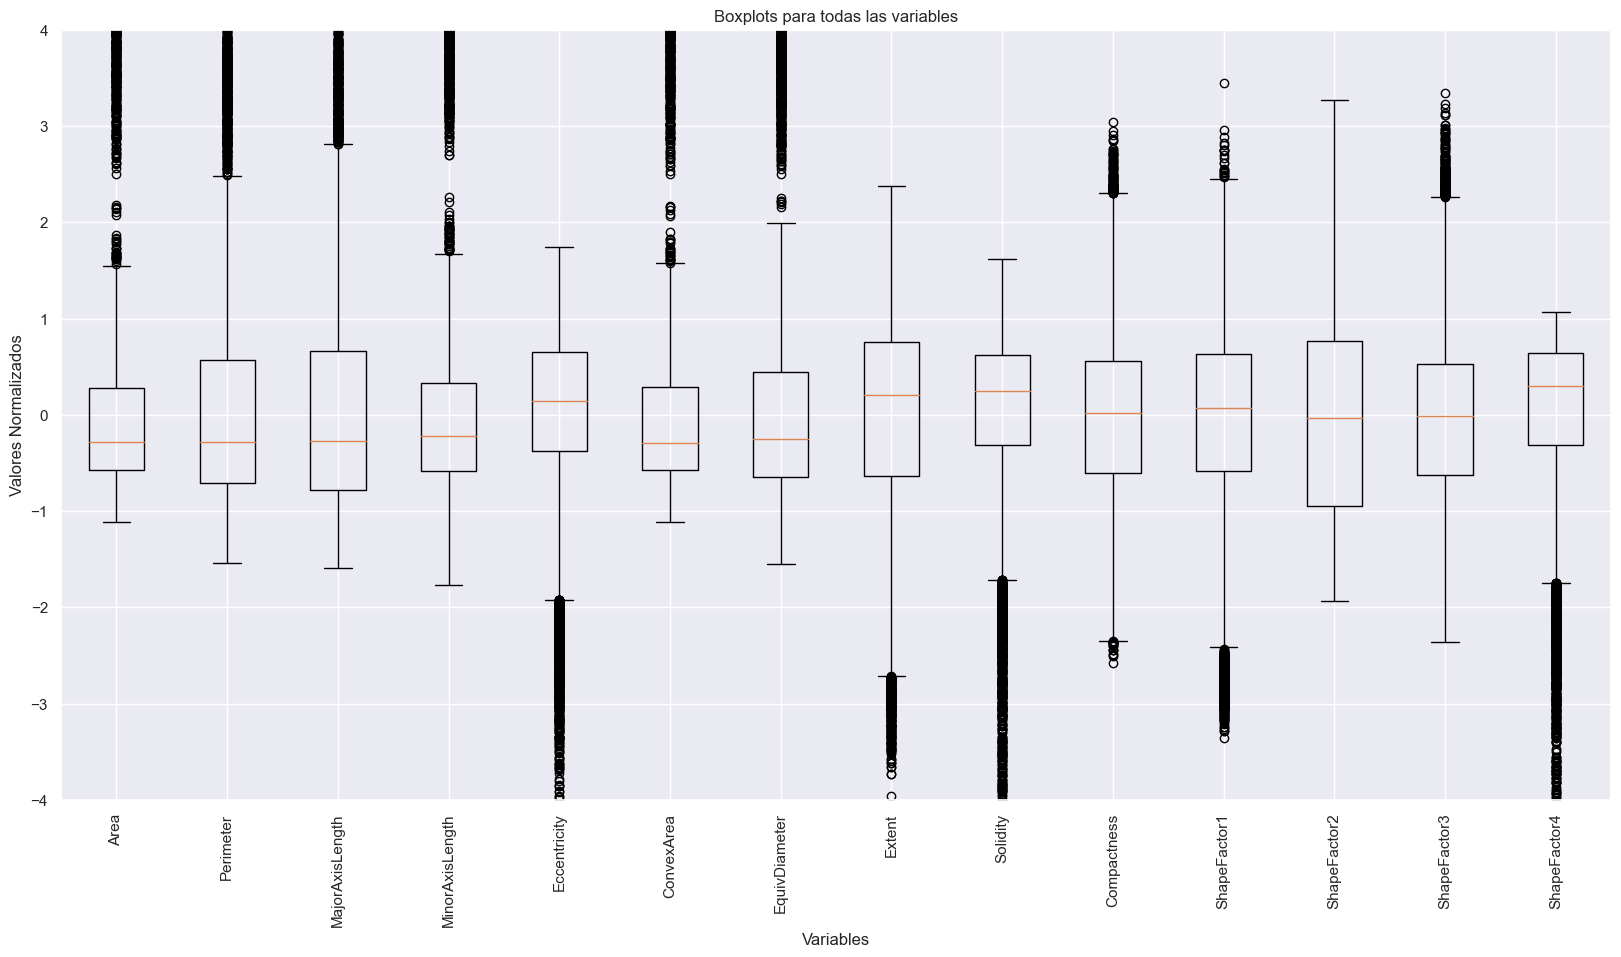

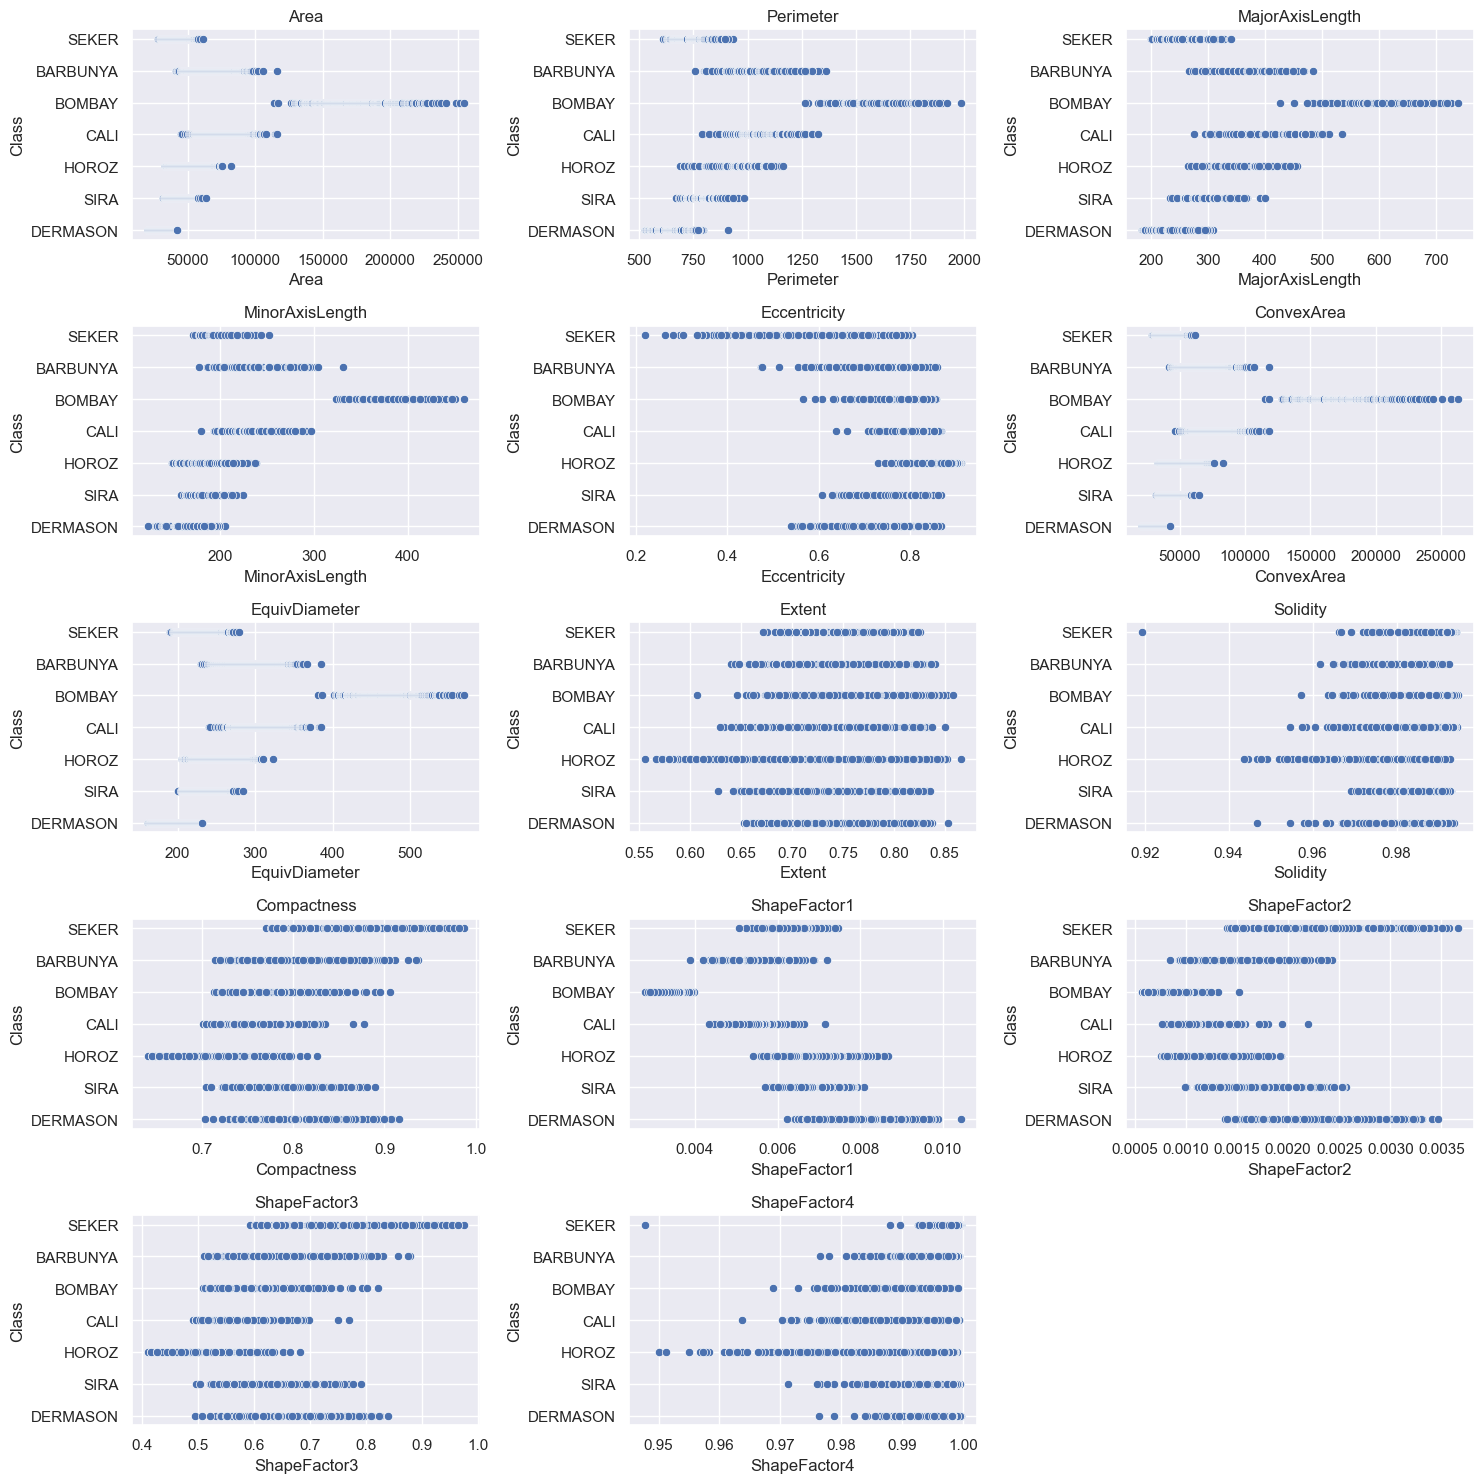

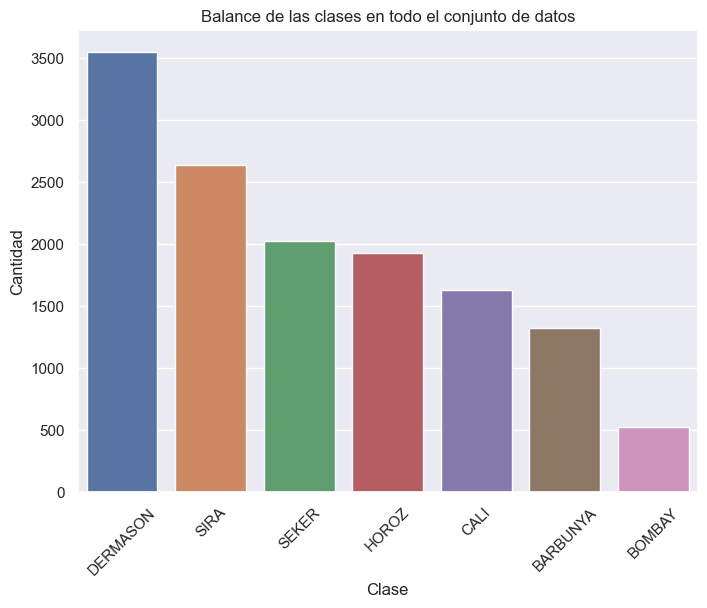

In [8]:
info(df)
graficos(df)

## Creamos nuestro modelo

Calculamos las metricas a agregar al modelo

In [9]:
df['aspect_radio'] = df['MajorAxisLength']/df['MinorAxisLength']
df['roundness'] = (4 * math.pi * df['Area']) / df['Perimeter']**2

Convertimos las etiquetas categóricas en valores numéricos.

In [10]:
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])


class_mapping = dict(zip( label_encoder.transform(label_encoder.classes_), label_encoder.classes_))



print("Mapeo de nombres de clases a números:")
print(class_mapping)

Mapeo de nombres de clases a números:
{0: 'BARBUNYA', 1: 'BOMBAY', 2: 'CALI', 3: 'DERMASON', 4: 'HOROZ', 5: 'SEKER', 6: 'SIRA'}


Separamos nuestra variable target de nuestras variables características

In [11]:
X = df.iloc[:, list(range(0, 14)) + list(range(15, 17))].values
y = df.iloc[:, 14].values

Dividimos en train y test nuestros datos

In [12]:
# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar características numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

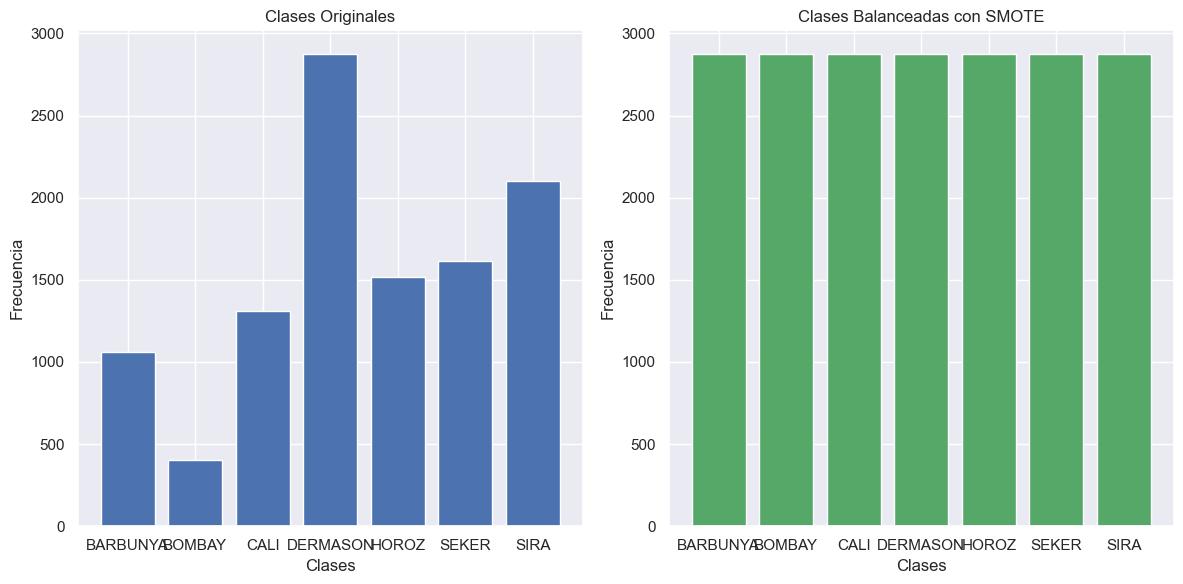

In [14]:
unique, counts = np.unique(y_train, return_counts=True)
original_counts = dict(zip(unique, counts))

unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
balanced_counts = dict(zip(unique_balanced, counts_balanced))

# Crear gráfico de barras comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

original_labels = [class_mapping[num] for num in list(unique)]
balanced_labels = [class_mapping[num] for num in list(unique_balanced)]

# Gráfico de barras para clases originales
ax1.bar(original_labels, original_counts.values(), color='b')
ax1.set_title('Clases Originales')
ax1.set_xlabel('Clases')
ax1.set_ylabel('Frecuencia')

# Gráfico de barras para clases balanceadas con SMOTE
ax2.bar(balanced_labels, balanced_counts.values(), color='g')
ax2.set_title('Clases Balanceadas con SMOTE')
ax2.set_xlabel('Clases')
ax2.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Creamos nuestra Red Neuronal

In [15]:
# Defino modelo
model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(16,)),
tf.keras.layers.Dense(units=10, activation="sigmoid"),
tf.keras.layers.Dense(units=7, activation="softmax")
])

Configuramos nuestro modelo de Red Neuronal, definiendo el optimizador a "Adam" como optimizador del modelo con un learning rate del 0.05. La funcion de perdida que usaremos es la SCCE que es adecuada para problemas de clasifiación multiclases. Y por ultimo evaluamos mediante el 'accuracy'.
Usaremos 20 epocas para entrenar el modelo y en lotes de 32, lo que significa que el modelo verá los datos de entrenamiento 20 veces en lotes de 32 muestras cada vez.

Modelo con clases desbalanceadas

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split= 0.2)


Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7621 - loss: 0.6440 - val_accuracy: 0.9201 - val_loss: 0.2436
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9116 - loss: 0.2373 - val_accuracy: 0.8930 - val_loss: 0.2986
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9165 - loss: 0.2314 - val_accuracy: 0.9164 - val_loss: 0.2306
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9165 - loss: 0.2210 - val_accuracy: 0.9109 - val_loss: 0.2585
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9168 - loss: 0.2178 - val_accuracy: 0.9206 - val_loss: 0.2402
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9192 - loss: 0.2311 - val_accuracy: 0.9137 - val_loss: 0.2435
Epoch 7/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9245 - loss: 0.2153 - val_accuracy: 0.9183 - val_loss: 0.2283
Epoch 8/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9206 - loss: 0.2186 - val_accuracy: 0.

Modelo con clases balanceadas

In [17]:
model_bal = tf.keras.models.clone_model(model)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model_bal.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])




history_bal = model_bal.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8486 - loss: 0.4703 - val_accuracy: 0.9217 - val_loss: 0.2286
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9327 - loss: 0.1944 - val_accuracy: 0.9021 - val_loss: 0.3071
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9323 - loss: 0.1923 - val_accuracy: 0.9461 - val_loss: 0.1766
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9398 - loss: 0.1732 - val_accuracy: 0.9292 - val_loss: 0.1780
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9362 - loss: 0.1761 - val_accuracy: 0.9165 - val_loss: 0.2314
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1756 - val_accuracy: 0.9170 - val_loss: 0.2255
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9338 - loss: 0.1873 - val_accuracy: 0.9419 - val_loss: 0.1664
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9390 - loss: 0.1795 - val_accuracy: 0.

Una vez que termina el entrenamiento analizamos las perdidas del modelo tanto en entrenamiento como en validación. Esto nos va a dar información sobre cómo la pérdida del modelo cambia durante el entrenamiento y si hay signos de overfitting o underfitting.

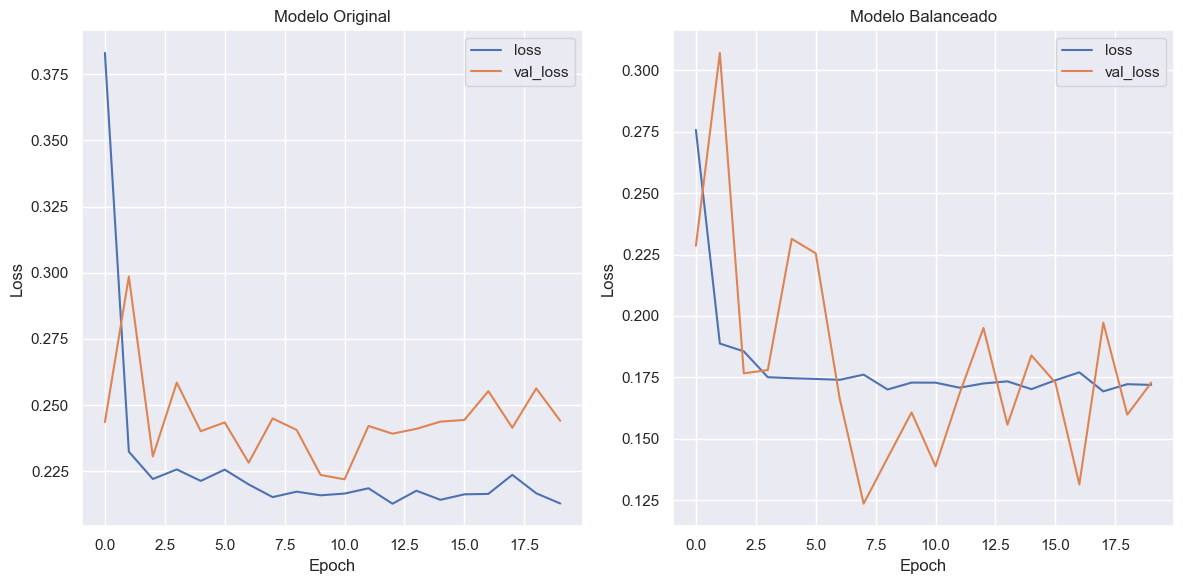

In [18]:
# Graficar las curvas de pérdida y validación lado a lado
plt.figure(figsize=(12, 6))

# Gráfico para el modelo original
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Modelo Original')
plt.legend()

# Gráfico para el modelo balanceado
plt.subplot(1, 2, 2)
plt.plot(history_bal.history['loss'], label='loss')
plt.plot(history_bal.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Modelo Balanceado')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Evaluar el modelo con los datos de prueba
loss, accuracy = model.evaluate(X_test_scaled, y_test)
loss_bal, accuracy_bal = model_bal.evaluate(X_test_scaled, y_test)

# Imprimir la pérdida y la precisión del modelo en los datos de prueba
print(f'Loss en datos de prueba sin balancear: {round(loss, 3 )}')
print(f'Precisión en datos de prueba sin balancear: {round(accuracy, 3 ) }')
print(f'Loss en datos de prueba balanceado: {round(loss_bal, 3 )}')
print(f'Precisión en datos de prueba balanceado: {round(accuracy_bal, 3 ) }')

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.1956
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9327 - loss: 0.2101
Loss en datos de prueba sin balancear: 0.211
Precisión en datos de prueba sin balancear: 0.923
Loss en datos de prueba balanceado: 0.223
Precisión en datos de prueba balanceado: 0.926


In [20]:
def plot_confusion_matrices(matrix1, matrix2, title1='Matriz 1', title2='Matriz 2'):
    # Crear figura y subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plotear primera matriz de confusión
    sns.heatmap(matrix1, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_xlabel('Clase Predicha')
    axes[0].set_ylabel('Clase Verdadera')
    axes[0].set_title(title1)

    # Plotear segunda matriz de confusión
    sns.heatmap(matrix2, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_xlabel('Clase Predicha')
    axes[1].set_ylabel('Clase Verdadera')
    axes[1].set_title(title2)

    # Ajustar el espaciado y mostrar la figura
    plt.tight_layout()
    plt.show()

In [21]:
def matriz_confusion(model, X_test_scaled, y_test, label_encoder):
    # Realizar predicciones para todos los ejemplos del conjunto de prueba
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Generar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred_classes)
    
    return cm

In [22]:
def reporte_class(model, X_test_scaled, y_test, label_encoder):
    
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Generar el reporte de clasificación
    report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
    
    # Convertir el reporte a un DataFrame
    report_df = pd.DataFrame(report).transpose()

    report_df.drop(columns=["support"], inplace=True)

    # Visualizar el reporte de clasificación
    plt.figure(figsize=(12, 7))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)
    plt.title('Reporte de Clasificación')
    plt.show()

In [23]:
matriz = matriz_confusion(model, X_test_scaled, y_test, label_encoder)
matriz_bal = matriz_confusion(model_bal, X_test_scaled, y_test, label_encoder)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


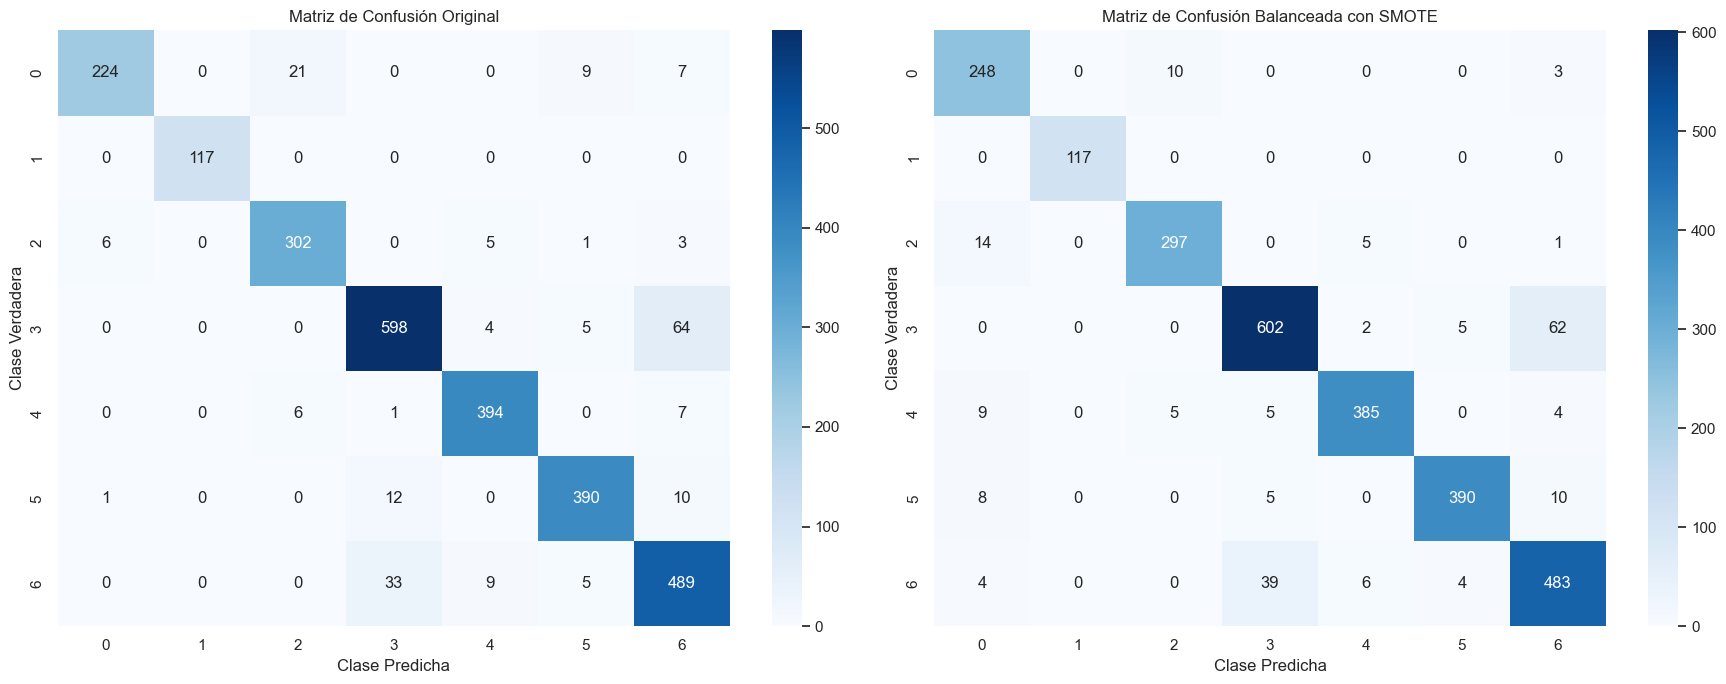

In [24]:
plot_confusion_matrices(matriz, matriz_bal, title1='Matriz de Confusión Original', title2='Matriz de Confusión Balanceada con SMOTE')


Algunas conclusiones:
- La precisión tanto en el conjunto de entrenamiento como en el de validación es relativamente alta, lo que indica que el modelo está aprendiendo bien los patrones en los datos.
- No parece haber señales evidentes de overfitting (alta precisión en el conjunto de entrenamiento pero baja en el de validación) o underfitting (baja precisión en ambos conjuntos).
- La precisión en el conjunto de validación se mantiene en un nivel relativamente alto y cercano al conjunto de entrenamiento, lo que sugiere que el modelo generaliza bien a datos no vistos.
- El desbalanceo de clases podemos ver que no afecta tanto al rendimiento del modelo, ya que realizando un over sampling de las clases minoritarias apenas mejora el modelo.